EAI 6010 <br>
Final Project <br>

Model 2 Training - Text Categorization <br>

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Data Input

In [ ]:
data = pd.read_csv('/content/drive/My Drive/EAI Project/merged_data_file.csv')
data.head(5)

,Unnamed: 0,Category,Description,Title,Unnamed: 0.1,Video Id,file
0,0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,0,i9E_Blai8vk,Collected_data_raw1.csv
1,1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,1,UBvJKs9eW3I,Collected_data_raw1.csv
2,2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,2,jeIQ_Z35HZ4,Collected_data_raw1.csv
3,3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",3,EthqIhPtd2I,Collected_data_raw1.csv
4,4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,4,X0F0Dh8ut3U,Collected_data_raw1.csv


In [ ]:
data.shape

(29245, 7)

### Data Cleaning

#### Removing NULL values

In [ ]:
del data['Unnamed: 0']
del data['Unnamed: 0.1']
del data['file']
data.isnull().sum()
df = data[data['Description'].notnull()]
df.head()

,Category,Description,Title,Video Id
0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,i9E_Blai8vk
1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,UBvJKs9eW3I
2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,jeIQ_Z35HZ4
3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",EthqIhPtd2I
4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,X0F0Dh8ut3U


#### Setting Index

In [ ]:
df = df.drop_duplicates(subset = 'Video Id')
boolean = df['Video Id'].duplicated().any()
print(boolean)
df.set_index('Video Id')
df.head()

False


,Category,Description,Title,Video Id
0,travel,DISCLAIMER* Please do not ride elephants when ...,Welcome to Bali | Travel Vlog | Priscilla Lee,i9E_Blai8vk
1,travel,Had the most amazing experience in Finland for...,FINLAND VACATION: TRAVEL VLOG,UBvJKs9eW3I
2,travel,Hello loves Today's video is the Vlog of my tr...,MYKONOS GREECE TRAVEL VLOG 2020 | Living our ...,jeIQ_Z35HZ4
3,travel,Thank you so much for watching! I hope you fou...,"TRAVEL VLOG: SANTORINI, GREECE",EthqIhPtd2I
4,travel,Las Vegas Travel Vlog 2020 - Pandemic Version....,Las Vegas Travel Vlog 2020 | Pandemic Edition,X0F0Dh8ut3U


#### Removing digits and special charecters

In [ ]:
df['Category'] = df['Category'].str.replace(r'\d+','')
df['Description'] = df['Description'].str.replace(r'\d+','')
df['Title'] = df['Title'].str.replace(r'\d+','')
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df['Title'] = df['Title'].str.replace(char, ' ')
    df['Description'] = df['Description'].str.replace(char, ' ')
    df['Category'] = df['Category'].str.replace(char, ' ')

#### Removing Smilies

In [ ]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
for i, row in df.iterrows():
    text_t = remove_emoji(row['Title'])
    text_d = remove_emoji(row['Description'])
    df.at[i,'Title']= text_t
    df.at[i,'Description'] = text_d

#### Retaining only english words

In [ ]:
for i, row in df.iterrows():
    text_t = ' '.join([w for w in row['Title'].split() if wordnet.synsets(w)])
    df.at[i,'Title'] = text_t
    text_d = ' '.join([w for w in row['Description'].split() if wordnet.synsets(w)])
    df.at[i,'Description'] = text_d

#### Removing stop words

In [ ]:
for i, row in df.iterrows():
    word_list_t = row['Title'].lower().split() 
    filtered_words = [word for word in word_list_t if word not in stopwords.words('english')]
    text_t = ' '.join(filtered_words)
    df.at[i,'Title']= text_t
    word_list_d = row['Description'].lower().split() 
    filtered_words = [word for word in word_list_d if word not in stopwords.words('english')]
    text_d = ' '.join(filtered_words)
    df.at[i,'Description'] = text_d

In [ ]:
df.Category.value_counts()

sports                    2984
nature                    2526
science and technology    2499
travel                    2431
food                      2318
art and music             2167
manufacturing             1932
adventure                 1575
history                   1298
Name: Category, dtype: int64

### Tokenization

In [ ]:
# Tokenization
df['descriptions_token'] = df['Description'].apply(lambda x: x.split())

### Vectorization

In [ ]:
def token_check(x,model):
  """
  1.Check if the token exists in the word2vec model vocab. 
  2.Check if the length of the token is greater than 3 
  """
  token_list=[]
  for i in x:
      if len(i) > 3 and i in model.vocab:
          token_list.append(i)
      else:
          continue
  return token_list

In [ ]:
def word_vector(tokens,size,model):

  """Averaging the word vectors"""
  
  vec = np.zeros(size).reshape((1, size))
  count = 0
  for word in tokens:
    vec += model[word].reshape((1, size))
    count += 1.
  if count != 0:
      vec /= count
  return vec



#### Loading Word Embedding Model 


In [ ]:
from gensim.models import Word2Vec,KeyedVectors

In [ ]:
#Download the Google Word Embeddings
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#Load the word2vec pre trained Model to get the word embeddings for each token
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz',binary=True,limit=1000000)

df['descriptions_token'] = df['descriptions_token'].apply(lambda x:token_check(x,model))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


####Averaging the word vectors in the descriptions before feeding the data to a model.

In [ ]:
df.reset_index(drop=True, inplace=True)

wordvec_arrays = np.zeros((len(df.descriptions_token),300))

for i in range(len(df.descriptions_token)):
  wordvec_arrays[i,:] = word_vector(df.descriptions_token[i],300,model)

vectorized_df = pd.DataFrame(wordvec_arrays)

#### One Hot Target Variable

In [ ]:
target_one_hot_encoded = pd.get_dummies(df['Category'])

In [ ]:
target_one_hot_encoded.head()

,adventure,art and music,food,history,manufacturing,nature,science and technology,sports,travel
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,1


#### Merging the vectorized DF and Target

In [ ]:
dataset = pd.merge(vectorized_df,target_one_hot_encoded,left_index=True, right_index=True)

#### Random Shuffling of Data before Splitting the Data

In [ ]:
dataset_shuffled = dataset.reindex(np.random.permutation(dataset.index))

### Data Splitting

In [ ]:
#splitting of data
from sklearn.model_selection import train_test_split

target=['adventure','art and music','food','history','manufacturing','nature','science and technology','sports','travel']
X = dataset_shuffled.loc[:,~dataset_shuffled.columns.isin(target)]
y = dataset_shuffled.loc[:,dataset_shuffled.columns.isin(target)]

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75,test_size=0.25,random_state=101)

### Modeling

#### Dense Neural Netork

In [ ]:
from keras import models
from keras import layers
from keras.layers import Dropout
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from keras import backend as K
from matplotlib import pyplot as plt

def NN_arch1(lrate=0.0001):
    model = models.Sequential()
    model.add(layers.Dense(300,input_dim = 300, activation='relu'))
    model.add(layers.Dense(5,activation='relu'))
    model.add(layers.Dense(4,activation='relu'))
    model.add(layers.Dense(9,activation='softmax'))
    opt = keras.optimizers.Adam(lr=lrate)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    return model

def NN_arch2(lrate=0.0001):
    model = models.Sequential()
    model.add(layers.Dense(300,input_dim = 300, activation='relu'))
    model.add(layers.Dense(5,activation='sigmoid'))
    model.add(Dropout(0.20))
    model.add(layers.Dense(6,activation='relu'))
    model.add(Dropout(0.10))
    #model.add(layers.Dense(4,activation='relu'))
    model.add(layers.Dense(9,activation='softmax'))
    opt = keras.optimizers.Adam(lr=lrate)
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
    return model

def model_fit(model,X_train,y_train,X_test,y_test,epoch_val=50):
    callbacks = EarlyStopping(monitor='val_loss',mode='min',patience=3)
    model.fit(X_train, y_train, epochs=epoch_val,batch_size=50)
    val_loss, val_acc = model.evaluate(X_test,y_test)
    print("val_loss, val_acc",val_loss, val_acc)
    return val_loss,val_acc

def history_plot(history):
    """ history plot """
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']
    training_acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.figure(figsize=(5,3))

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    #Visualize accuracy history
    plt.plot(epoch_count, training_acc, 'r--')
    plt.plot(epoch_count, test_acc, 'b-')
    plt.legend(['Training acc', 'Test acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.show();

In [ ]:
#model_NN = NN_arch1(0.00001)
#val_loss,val_acc = model_fit(model_NN,X_train,y_train,X_test,y_test,epoch_val=100)

#history = model_NN.fit(X_train,y_train,epochs=100,verbose=0,validation_data=(X_test, y_test)) 
#history_plot(history)

Epoch 1/100
148/148 [==============================] - 1s 6ms/step - loss: 0.3384 - accuracy: 0.2021 - val_loss: 0.3160 - val_accuracy: 0.2678
Epoch 2/100
148/148 [==============================] - 1s 4ms/step - loss: 0.3101 - accuracy: 0.2811 - val_loss: 0.2984 - val_accuracy: 0.3416
Epoch 3/100
148/148 [==============================] - 1s 4ms/step - loss: 0.2987 - accuracy: 0.3307 - val_loss: 0.2862 - val_accuracy: 0.4346
Epoch 4/100
148/148 [==============================] - 1s 4ms/step - loss: 0.2891 - accuracy: 0.3795 - val_loss: 0.2750 - val_accuracy: 0.4488
Epoch 5/100
148/148 [==============================] - 1s 4ms/step - loss: 0.2832 - accuracy: 0.3980 - val_loss: 0.2683 - val_accuracy: 0.4648
Epoch 6/100
148/148 [==============================] - 1s 4ms/step - loss: 0.2769 - accuracy: 0.4120 - val_loss: 0.2622 - val_accuracy: 0.4839
Epoch 7/100
148/148 [==============================] - 1s 4ms/step - loss: 0.2729 - accuracy: 0.4214 - val_loss: 0.2579 - val_accuracy: 0.4995

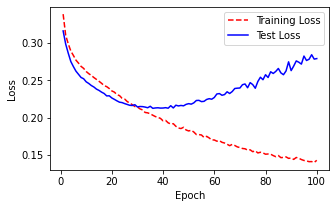

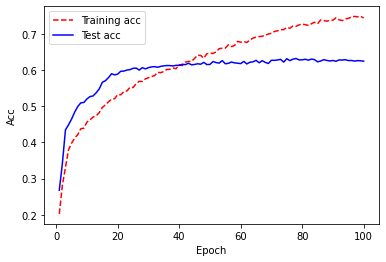

In [ ]:
model_NN = NN_arch2(0.0009)
#val_loss,val_acc = model_fit(model_NN,100)
history = model_NN.fit(X_train,y_train,epochs=100,verbose=1,batch_size=100,validation_data=(X_test, y_test)) 
history_plot(history)

In [ ]:
model_NN.save('/content/drive/My Drive/EAI Project/model_text_categorize.h5')

### Predictions

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/EAI Project/model_text_categorize.h5')

In [ ]:
#Download the Google Word Embeddings
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#Load the word2vec pre trained Model to get the word embeddings for each token
model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz',binary=True,limit=1000000)

In [ ]:
def clean_description_text(description):
  description = description.replace(r'\d+','')
  spec_chars = ["!",'"',"#","%","&","'","(",")",
                "*","+",",","-",".","/",":",";","<",
                "=",">","?","@","[","\\","]","^","_",
                "`","{","|","}","~","–"]
  for char in spec_chars:
      description = description.replace(char, ' ')

  word_list_t = description.lower().split() 
 
  filtered_words = [word for word in word_list_t if word not in stopwords.words('english')]
  text = ' '.join(filtered_words)
  return text

In [ ]:
description = 'robot'

clean_description = clean_description_text(description)
description_tokens = list(clean_description.split(" "))
description_tokens_filtered = token_check(description_tokens,model)

_arrays = np.zeros((1, 300))
_arrays[0,:] = word_vector(description_tokens_filtered,300,model)
vectorized_array = pd.DataFrame(_arrays)

pred = loaded_model.predict([vectorized_array.iloc[:,0:300]])

value = np.argmax(pred,axis=-1)
labels = ['adventure','art and music','food','history','manufacturing','nature','science and technology','sports','travel']

print("Predicted Label : " , labels[value.item()])  

Predicted Label :  science and technology


In [ ]:
#Light GBM

In [ ]:
vectorized_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.024719,0.063202,-0.054357,0.113420,-0.110855,0.028269,0.086772,-0.029327,0.051575,0.005269,0.038310,-0.120341,-0.042625,0.011214,-0.128139,0.041258,-0.017349,0.038676,-0.050978,-0.139852,0.098297,0.043651,0.021281,0.007729,0.025734,-0.002042,-0.113566,-0.008982,0.041880,-0.038737,-0.009405,-0.022547,-0.104731,0.003448,0.015572,-0.045771,0.006755,0.003609,0.035243,0.053406,...,-0.098704,-0.009165,0.019043,0.092946,0.022176,0.119497,0.015867,-0.021723,-0.044098,-0.079524,0.053472,0.129697,0.126058,0.100118,0.116834,-0.082703,-0.073250,-0.054586,-0.072942,-0.008128,0.008311,-0.067017,-0.025765,0.061768,-0.040629,-0.002009,-0.084086,0.036494,0.097270,-0.013468,-0.083984,0.073039,-0.088826,-0.074422,0.046855,-0.055272,0.020864,-0.060996,-0.037821,-0.071991
1,0.053044,0.063425,-0.031696,-0.004019,0.037795,-0.002310,0.018555,-0.098257,0.012489,0.060678,0.141611,-0.130061,-0.034370,-0.054537,-0.008369,-0.015133,-0.057387,0.080848,-0.013221,-0.036969,-0.000776,0.143517,-0.075693,0.019071,0.031250,-0.049478,-0.069364,0.053035,-0.020245,-0.083712,-0.051706,-0.022545,-0.026743,0.070033,0.059204,-0.147931,0.017657,-0.097722,0.010686,0.088328,...,-0.089679,-0.061521,0.036245,0.108322,0.022874,0.160208,0.048302,-0.027616,-0.119150,0.063763,0.047852,0.057026,0.119638,-0.014998,0.160140,-0.208120,-0.059831,-0.033367,-0.019663,-0.106182,0.098695,0.007787,0.095028,0.148043,-0.043959,-0.113831,-0.112662,0.087421,0.003634,0.130540,-0.143508,0.016310,-0.132531,0.102217,-0.067932,-0.009230,-0.036093,-0.053872,0.098778,-0.041584
2,-0.010413,0.068515,0.037320,0.090747,0.021960,0.068805,0.011243,-0.160822,0.073511,0.099237,0.022519,-0.166968,-0.023685,-0.044324,-0.035971,0.036217,0.021362,0.072652,0.029749,-0.066724,0.058398,0.123447,0.073291,-0.049741,0.056659,-0.010645,-0.023938,0.061670,0.091656,-0.026440,0.025287,0.055801,-0.021582,-0.015601,0.044739,0.007532,0.059222,0.015021,0.087549,0.138232,...,-0.032178,0.024707,0.014124,0.032556,0.102150,0.091245,0.004150,0.047119,-0.048860,0.005798,0.001782,0.146973,0.123962,0.089111,0.130322,-0.183850,-0.068683,-0.041821,-0.140900,-0.005176,0.006763,-0.039038,-0.080346,0.117554,0.042651,0.006818,-0.117627,0.044479,-0.038940,0.116625,-0.099612,0.002881,-0.130408,-0.058983,-0.012489,-0.049695,-0.031040,-0.092152,0.014050,-0.055670
3,0.063796,0.067345,0.041410,0.090609,-0.032114,0.038180,-0.007963,-0.212551,0.053828,0.043058,0.014503,-0.097168,-0.019400,0.049016,-0.069336,0.029297,0.050990,0.183519,0.004864,-0.058077,0.031034,0.161846,-0.032086,0.004132,0.058763,-0.049880,0.008874,-0.058890,0.047386,-0.068067,-0.061658,0.039431,-0.070679,0.059199,0.046244,-0.035866,0.036535,-0.026292,0.040837,0.054650,...,-0.013945,0.102948,0.048039,0.042917,0.024320,0.144686,0.006377,0.015587,-0.057204,0.037601,0.121500,0.165931,0.086623,0.060312,0.134399,-0.173136,-0.094019,-0.037400,-0.025292,-0.075612,-0.004934,-0.048978,-0.076074,0.010148,-0.041053,0.051136,-0.147104,0.138247,0.003512,0.081590,-0.062913,-0.012292,-0.068904,-0.011928,0.029579,-0.118211,0.068819,-0.047032,0.068650,-0.085679
4,0.076660,0.065318,0.030645,0.078562,-0.045288,0.002884,-0.085266,-0.124573,0.165507,0.013784,0.013814,-0.194590,-0.023689,0.041428,-0.037084,0.056920,0.096191,0.130656,0.092770,-0.100802,-0.075701,0.094421,0.037587,-0.012344,-0.024419,0.029399,-0.001485,-0.011871,0.005681,-0.047638,-0.041148,-0.028509,-0.008911,-0.004852,-0.025019,-0.053009,-0.042796,0.004440,0.005035,0.055847,...,0.003479,-0.003520,0.152140,0.037638,0.039734,0.160116,0.012777,-0.031026,-0.077305,-0.007955,0.053426,0.062121,0.019246,0.014420,0.083221,-0.134034,-0.092049,-0.030370,-0.081985,0.097251,-0.042511,-0.054047,-0.015841,-0.013354,0.099482,-0.064321,-0.085246,0.034932,-0.032227,0.059527,

In [ ]:
vectorized_df_lgbm = vectorized_df

In [ ]:
vectorized_df_lgbm['Target'] = df.Category

In [ ]:
import pandas
from sklearn import preprocessing 

def target_label_encoding(x):
  labels = ['adventure','art and music','food','history','manufacturing','nature','science and technology','sports','travel']
  if x == labels[0]:
    return 0
  elif x == labels[1]:
    return 1
  elif x == labels[2]:
    return 2
  elif x == labels[3]:
    return 3
  elif x == labels[4]:
    return 4
  elif x == labels[5]:
    return 5
  elif x == labels[6]:
    return 6
  elif x == labels[7]:
    return 7
  else:
    return 8

In [ ]:
vectorized_df_lgbm.Target = vectorized_df_lgbm.Target.apply(lambda x : target_label_encoding(x))

In [ ]:
dataset_shuffled = vectorized_df.reindex(np.random.permutation(vectorized_df.index))

In [ ]:
from sklearn.model_selection import train_test_split

#target=['adventure','art and music','food','history','manufacturing','nature','science and technology','sports','travel']
X = dataset_shuffled.loc[:,~dataset_shuffled.columns.isin(['Target'])]
y = dataset_shuffled.loc[:,dataset_shuffled.columns.isin(['Target'])]

X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.75,test_size=0.25,random_state=101)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMClassifier(boosting_type='gbdt', 
                               learning_rate = 0.125, 
                               metric = 'multiclass', n_estimators = 20,
                               num_leaves = 38)

param_grid = {
    'n_estimators': [x for x in [75,100]],
    'learning_rate': [0.01,0.1,0.2],
    'num_leaves': [5,10],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multiclass'],
    'lambda_l1' : [0.10],
    'lambda_l2' : [0.20],
    'random_state' : [501]}

gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train.values.ravel(),eval_set = [(X_test, y_test)],eval_metric = ['multi_logloss'],early_stopping_rounds = 10)

print('Best parameters found by grid search are:', gridsearch.best_params_)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Streaming output truncated to the last 5000 lines.
[67]	valid_0's multi_logloss: 1.85351	valid_0's multi_logloss: 1.85351
[68]	valid_0's multi_logloss: 1.85022	valid_0's multi_logloss: 1.85022
[69]	valid_0's multi_logloss: 1.84697	valid_0's multi_logloss: 1.84697
[70]	valid_0's multi_logloss: 1.8438	valid_0's multi_logloss: 1.8438
[71]	valid_0's multi_logloss: 1.84058	valid_0's multi_logloss: 1.84058
[72]	valid_0's multi_logloss: 1.83745	valid_0's multi_logloss: 1.83745
[73]	valid_0's multi_logloss: 1.83425	valid_0's multi_logloss: 1.83425
[74]	valid_0's multi_logloss: 1.83141	valid_0's multi_logloss: 1.83141
[75]	valid_0's multi_logloss: 1.82842	valid_0's multi_logloss: 1.82842
Did not meet early stopping. Best iteration is:
[75]	valid_0's multi_logloss: 1.82842	valid_0's multi_logloss: 1.82842
[1]	valid_0's multi_logloss: 2.1652	valid_0's multi_logloss: 2.1652
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 2.15732	valid_0's multi_logloss: 2

In [ ]:
gbm = lgb.LGBMClassifier(boosting_type= 'gbdt', learning_rate=0.1, 
                         n_estimators=400, num_leaves= 10,
                         lambda_l1=0.5,
                         lambda_l2=0.4,
                         objective= 'multiclass', random_state= 501)

gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['multiclass'],
early_stopping_rounds=20)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's multi_logloss: 2.09544
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's multi_logloss: 2.03659
[3]	valid_0's multi_logloss: 1.9871
[4]	valid_0's multi_logloss: 1.94313
[5]	valid_0's multi_logloss: 1.90463
[6]	valid_0's multi_logloss: 1.86879
[7]	valid_0's multi_logloss: 1.83664
[8]	valid_0's multi_logloss: 1.8068
[9]	valid_0's multi_logloss: 1.7792
[10]	valid_0's multi_logloss: 1.75291
[11]	valid_0's multi_logloss: 1.7294
[12]	valid_0's multi_logloss: 1.70718
[13]	valid_0's multi_logloss: 1.68588
[14]	valid_0's multi_logloss: 1.66635
[15]	valid_0's multi_logloss: 1.64808
[16]	valid_0's multi_logloss: 1.63034
[17]	valid_0's multi_logloss: 1.61445
[18]	valid_0's multi_logloss: 1.5994
[19]	valid_0's multi_logloss: 1.58452
[20]	valid_0's multi_logloss: 1.57063
[21]	valid_0's multi_logloss: 1.55733
[22]	valid_0's multi_logloss: 1.54412
[23]	valid_0's multi_logloss: 1.53156
[24]	valid_0's multi_logloss: 1.5199
[25]	valid_0's multi_logloss: 1.50774
[26

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', lambda_l1=0.5, lambda_l2=0.4,
               learning_rate=0.1, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=400,
               n_jobs=-1, num_leaves=10, objective='multiclass',
               random_state=501, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
gbm.score(X_train,y_train)

0.9643846725687639

In [ ]:
# Test Metric Validation
y_pred_prob = gbm.predict_proba(X_test)
pred_list=[]
for i in range(len(y_pred_prob)):
  pred_list.append(np.argmax(y_pred_prob[i]))

test_predictions  = pd.DataFrame({'prediction' : pred_list,'Actual':y_test.Target})

from sklearn import metrics
print(metrics.accuracy_score(test_predictions.prediction, test_predictions.Actual))

0.6685586863977295


0.6716997411561692
